In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import time

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 20

Device: cuda:0


In [3]:

# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([2, 4, 9, 3, 6, 6, 7, 5, 1, 4])


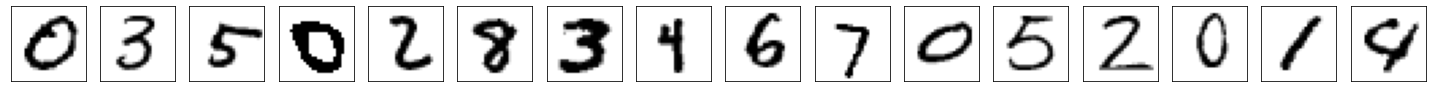

In [5]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )


    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [7]:
model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

In [8]:
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader,
                 log=100, 
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_index, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            if batch_index % log ==0:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_index,
                          len(train_loader), loss))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [9]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        log=50)

Epoch: 001/020 | Batch 0000/0235 | Loss: 178.2909
Epoch: 001/020 | Batch 0050/0235 | Loss: 57.5945
Epoch: 001/020 | Batch 0100/0235 | Loss: 53.9829
Epoch: 001/020 | Batch 0150/0235 | Loss: 52.3109
Epoch: 001/020 | Batch 0200/0235 | Loss: 50.2084
Time elapsed: 0.21 min
Epoch: 002/020 | Batch 0000/0235 | Loss: 47.5917
Epoch: 002/020 | Batch 0050/0235 | Loss: 46.0130
Epoch: 002/020 | Batch 0100/0235 | Loss: 44.3193
Epoch: 002/020 | Batch 0150/0235 | Loss: 45.1406
Epoch: 002/020 | Batch 0200/0235 | Loss: 43.1870
Time elapsed: 0.34 min
Epoch: 003/020 | Batch 0000/0235 | Loss: 42.2008
Epoch: 003/020 | Batch 0050/0235 | Loss: 42.4470
Epoch: 003/020 | Batch 0100/0235 | Loss: 42.5703
Epoch: 003/020 | Batch 0150/0235 | Loss: 43.2049
Epoch: 003/020 | Batch 0200/0235 | Loss: 41.7850
Time elapsed: 0.47 min
Epoch: 004/020 | Batch 0000/0235 | Loss: 41.1530
Epoch: 004/020 | Batch 0050/0235 | Loss: 40.7578
Epoch: 004/020 | Batch 0100/0235 | Loss: 40.6914
Epoch: 004/020 | Batch 0150/0235 | Loss: 40.7376

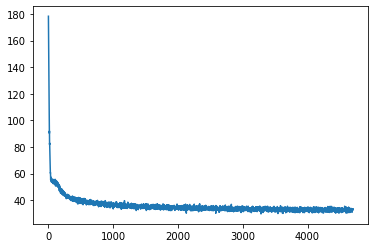

In [10]:
plt.figure()
plt.plot(range(len(log_dict['train_reconstruction_loss_per_batch'])),(log_dict['train_reconstruction_loss_per_batch']))

In [11]:
def plot_generated_images(data_loader, model, device, 
                          figsize=(20, 2.5), n_images=15):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_index, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)))

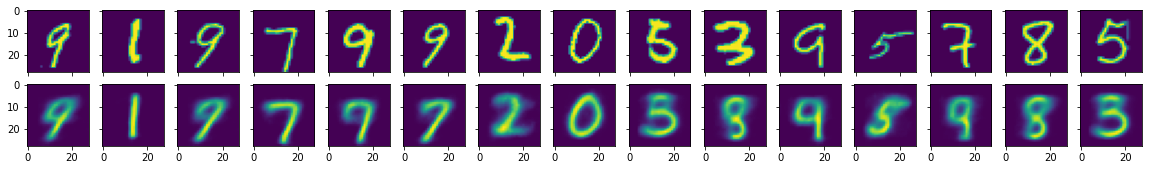

In [12]:


plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)           

